In [1]:
# Make module from local packages importable
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import yaml
import numpy as np
import matplotlib.pyplot as plt

from db_utils.db_connection import SumatraDB
os.chdir("..")

In [3]:
DATA_PATH="data"
RECORD_LABEL="20180702-103105"
RECORD_PATH=os.path.join(DATA_PATH, RECORD_LABEL)


# Query config from database
db = SumatraDB(db=".smt/records")
COLUMNS = ["label", "reason", "timestamp", "tags", "parameters_id", "version"]
record = db.get_filtered_by_label(COLUMNS, RECORD_LABEL)[0]
config = db.get_params_dic(record.params_id)

# Create folder for generated plots
if not os.path.exists("generated_plots"):
    os.mkdir("generated_plots")

config

{'class': 'src.test_retest.mri.unsupervised_features.Conv3DTupleAE',
 'params': {'config': {'keep_checkpoint_max': 1,
   'log_step_count_steps': 100,
   'save_checkpoints_steps': 100,
   'save_summary_steps': 1,
   'tf_random_seed': 42},
  'data_params': {'dump_out_dir': 'produced_data', 'not_needed': 'not'},
  'hooks': {'confusion_matrix': True,
   'icc_c1': True,
   'robustness_streamer_config': {'class': 'src.data.streaming.streamer_collections.MRIDiagnosePairStreamCollection',
    'params': {'diagnosis_pairs': {'different_patient': [['healthy',
        'healthy'],
       ['health_ad', 'health_ad'],
       ['healthy', 'health_ad']],
      'same_patient': [['healthy', 'healthy'], ['health_ad', 'health_ad']]},
     'stream_config': {'balanced_labels': ['healthy', 'health_ad'],
      'batch_size': -1,
      'data_sources': [{'glob_pattern': 'produced_data/ae_pairs_one_epoch/test_0/*_*.npy',
        'id_from_filename': {'regex_id_group': 1,
         'regexp': '.*/([AI0-9]+)_mni_aligned\

In [4]:
import importlib
# Load python class to construct object
def import_class(full_path):
    module_string = ".".join(full_path.split(".")[:-1])
    module = importlib.import_module(module_string)
    class_ = getattr(module, full_path.split(".")[-1])
    return class_
    
class_ = import_class(config["class"])
# Don't need streamer
s_class = config["params"]["streamer"]["class"]
s_class = import_class(s_class)
s_params = config["params"]["streamer"]["params"]
print(s_params)
csv_path = config["params"]["streamer"]["params"]["stream_config"]["meta_csv"]
config["params"]["streamer"]["params"]["stream_config"]["meta_csv"] = csv_path
streamer = s_class(**s_params)

config["params"]["streamer"] = None
obj = class_(**config["params"])
obj.streamer = streamer

/home/mhoerold/entrack/src/test_retest/mri/feature_analysis.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mhoerold/miniconda3/envs/thesis/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mhoerold/miniconda3/envs/thesis/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mhoerold/miniconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mhoerold/miniconda3/envs/thesis/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mhoerold/miniconda3/envs/thesis/lib/pyth

{'stream_config': {'balanced_labels': ['healthy', 'health_ad'], 'batch_size': 16, 'data_sources': [{'glob_pattern': 'brain_data/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/*_*.nii.gz', 'id_from_filename': {'regex_id_group': 1, 'regexp': '.*/([AI0-9]+)_mni_aligned\\.nii\\.gz'}, 'name': 'ADNI_AIBL'}], 'downsample': {'enabled': False, 'shape': [8, 8, 8]}, 'feature_collection': 'adni_aibl', 'meta_csv': 'data/raw/csv/adni_aibl__ad_hc.csv', 'meta_id_column': 'image_label', 'normalize_images': True, 'seed': 47, 'shuffle': True, 'train_ratio': 0.8}}
ADNI_AIBL has 200 files
36 files found but not specified meta csv
Number of files: 164
Number of files missing: 10930
Making balanced split
Achieved train ratio: 0.6219512195121951
>>>>>>>>> Sanity checks OK
>>>>>>>> Train stats
>>>>>>>>>>>>>>>>
>>>> Age stats, mean=75.4054054054054, std=7.778902373275021
>>>> Age diffences stats, mean=0.0, std=0.0
>>>> healthy count: 50
>>>> health_ad count: 98
>>>> Gender 0: 62 (0.4189189189189189)
>>>> Gender 1: 

In [5]:
# Construct estimator
est = tf.estimator.Estimator(
    model_fn=obj.model_fn,
    model_dir=RECORD_PATH,
    params=config["params"]["params"]
)
est.streamer = streamer

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'data/20180702-103105', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcf07bc2940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
preds = est.predict(streamer.get_input_fn(False))
print(est.streamer)
print(obj.streamer)
c = 0
for pred in preds:
    c += 1
    if c > 10:
        break

INFO:tensorflow:Calling model_fn.
Non conv layer needed
Non conv layer needed
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from data/20180702-103105/model.ckpt-20
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [7]:
pred.keys()

dict_keys(['input', 'encoding', 'decoding', 'file_name'])

0.72118986
35.573536
3.008857


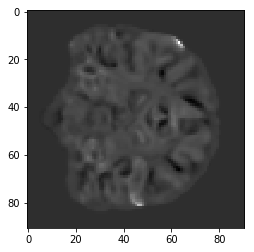

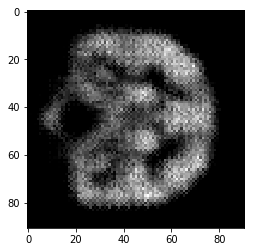

In [8]:
image_shape = (91, 109, 91)
dim = 50
reco = pred["decoding"]
reco = np.reshape(reco, image_shape)
inp = pred["input"]
inp = np.reshape(inp, image_shape)
plt.figure()
plt.imshow(inp[:, dim, :], cmap="gray")
plt.figure()
plt.imshow(reco[:, dim, :], cmap="gray")
print(np.mean((inp - reco) ** 2))
print(np.max(inp))
print(np.max(reco))

In [9]:
pred["file_name"]

array([b'304792_mni_aligned'], dtype=object)